# Vision

> This is functionality for getting visual information into python so our agent can process it.

In [ ]:
#| default_exp observation.vision
#| export
from algorithmic_gamer.utility.types import *
from algorithmic_gamer.utility.fuzzer import *

from typing import Union, Tuple, Any
from dataclasses import dataclass
from datetime import datetime
import importlib

import win32gui
import win32ui
import win32con
import win32api

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
#| hide
from nbdev.showdoc import *

#### win32 screen capture

In [ ]:
#| export
def win32_view(location: Union[Window, Region], time: bool = False) -> np.ndarray:
    """
    Capture a screenshot of the specified window or region on the desktop.
    
    Parameters:
    location (Window or Region): The window or region to capture.
    
    Returns:
    np.ndarray: The screenshot as a 3-channel image in RGB format.
    """
    hwin, region, width, height = f_get_region(location)

    # Create a device context (DC) for the window or desktop.
    hwindc = win32gui.GetWindowDC(hwin)
    srcdc = win32ui.CreateDCFromHandle(hwindc)
    
    # Create a compatible DC.
    memdc = srcdc.CreateCompatibleDC()
    
    # Create a bitmap object and select it into the memory DC.
    bmp = win32ui.CreateBitmap()
    bmp.CreateCompatibleBitmap(srcdc, width, height)
    memdc.SelectObject(bmp)
    
    # Perform a bit block transfer (BitBlt) from the window or desktop DC to the memory DC.
    memdc.BitBlt((0, 0), (width, height), srcdc, (int(region.left), int(region.top)), win32con.SRCCOPY)
    if time:
        write_time = datetime.utcnow()
    
    # Retrieve the bitmap bits as a signed integer array.
    signed_ints_array = bmp.GetBitmapBits(True)
    
    # Convert the array to an unsigned 8-bit integer NumPy array.
    img = np.frombuffer(signed_ints_array, dtype='uint8')
    # BGRA2RGB without cv2
    img = img.reshape(height, width, 4)[:, :, [2, 1, 0]]
        
    # Delete the DCs and the bitmap object.
    srcdc.DeleteDC()
    memdc.DeleteDC()
    win32gui.ReleaseDC(hwin, hwindc)
    win32gui.DeleteObject(bmp.GetHandle())
    
    if time:return img, write_time
    
    else: return img

In [ ]:
#| export
def f_get_region(location: Union[Window, Region]) -> Tuple[int, Region, int, int]:
    """
    Get the relevant handle and the region to be captured.
    
    Parameters:
    location (Window or Region): The window or region to capture.
    
    Returns:
    Tuple[int, Region, int, int]: A tuple containing the handle to the window or desktop,
        the region to be captured, and the width and height of the region.
    """
    if isinstance(location, Region):
        # Get the handle to the desktop window.
        hwin = win32gui.GetDesktopWindow()
        
        # Calculate the width and height of the region.
        width = location.right - location.left + 1
        height = location.bottom - location.top + 1
        
        return hwin, location, int(width), int(height)
    elif isinstance(location, Window):
        
        # Get the handle to the application window.
        hwin = win32gui.FindWindow(None, location.app_name)
        
        if location.sub_region is not None: # a subregion is defined
            width = location.sub_region.right - location.sub_region.left + 1
            height = location.sub_region.bottom - location.sub_region.top + 1
            
            return hwin, location.sub_region, int(width), int(height)
        else:# no subregion, capture the entire window
            
            # Get the dimensions of the client area.
            left, top, right, bottom = win32gui.GetClientRect(hwin)
            # Convert the client area coordinates to screen coordinates.
            left, top = win32gui.ClientToScreen(hwin, (left, top))
            right, bottom = win32gui.ClientToScreen(hwin, (right, bottom))

            # Get the width and height of the client area.
            width = right - left
            height = bottom - top
            
            ##TODO win32gui.FindWindow appears to return include margin shadows in the size
            return hwin, Region(left=0+7, top=0, right=right, bottom=bottom), int(width), int(height)

#### win32_view Region

screencapture of desktop at Region(left=480.0, top=270.0, right=1440.0, bottom=810.0)


<matplotlib.image.AxesImage>

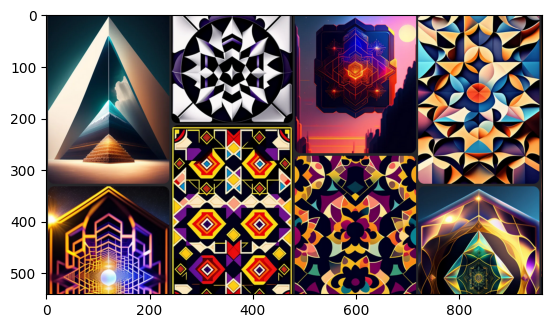

In [ ]:
#|eval: false
w = int(1920/2)
h = int(1080/2)
reg = Region(left=w-(w/2), top=h-(h/2), right=w+(w/2), bottom=h+(h/2))
img = win32_view(location=reg)
print(f'screencapture of desktop at {reg}')
plt.imshow(img)



#### win32_view Window

<matplotlib.image.AxesImage>

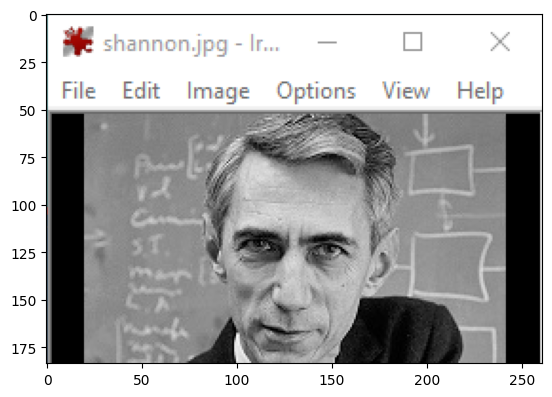

In [ ]:
#|eval: false
img = win32_view(location=Window(app_name=fuzzy_app('shannon')))
plt.imshow(img)

#### dxcam screen capture

[dxcam](https://github.com/ra1nty/DXcam) is a faster alternative `win32_view` but requires the creation of a `camera` instance for collecting screenshots, it also only supports `Region` currently.

In [ ]:
#| export
def dxcam_view(cam, location: Union[Window, Region], time: bool = False) -> np.ndarray:
    """
    This function captures an image from a specified camera view.
    
    Parameters:
    - cam: The camera object to capture an image from.
    - location (Union[Window, Region]): The location to capture the image from. Can be a Window or Region object.
    - time (bool): Whether to return the current UTC time along with the image. Default is False.
    
    Returns:
    - np.ndarray: The captured image.
    - datetime: The current UTC time (if time=True)
    """
    if isinstance(location, Window):
        raise Exception(f'location of type Window is currently not supported for dxcam_view, please use win32_view for Window support')
        
    elif isinstance(location, Region):
        img = cam.grab((int(location.left), int(location.top), int(location.right), int(location.bottom)))
        
        if time:return img, datetime.utcnow()
        else:return img


In [ ]:
#| export
def create_dxcam():
    """
    This function creates and returns a dxcam object.
    If dxcam is not found an exception will be raised.
    
    Returns:
    - dxcam object: The created dxcam object.
    """
    if importlib.util.find_spec("dxcam") is None:
        raise Exception(f'dxcam was not found, please install dxcam, "pip install dxcam"')
    else:
        import dxcam
        return dxcam.create()


screencapture of desktop at Region(left=480.0, top=270.0, right=1440.0, bottom=810.0)


<matplotlib.image.AxesImage>

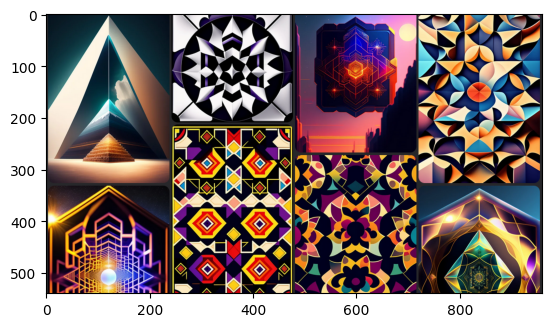

In [ ]:
#|eval: false
w = int(1920/2)
h = int(1080/2)
reg = Region(left=w-(w/2), top=h-(h/2), right=w+(w/2), bottom=h+(h/2))

cam = create_dxcam()
img = dxcam_view(cam, location=reg)
print(f'screencapture of desktop at {reg}')
plt.imshow(img)


In [ ]:
#|eval: false
%timeit win32_view(location=reg)
%timeit dxcam_view(cam, location=reg)

5.59 ms ± 98.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.1 µs ± 326 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### normalization 

In [ ]:
#| export
def f_naive_normalize_image(tensor):
    """Normalize a 3D tensor with values in the range [0, 255] to the range [-1, 1]
    
    Args:
        tensor: A 3D tensor with shape (h, w, 3) and values in the range [0, 255]
    
    Returns:
        A normalized version of the input tensor with values in the range [-1, 1]
    """
    # Divide the tensor by 255, multiply by 2, and subtract 1 to get a tensor with values in the range [-1, 1]
    normalized_tensor = (tensor / 255) * 2 - 1
    
    return normalized_tensor

In [ ]:
#|eval: false
f_naive_normalize_image(img)

array([[[-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        ...,
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824]],

       [[-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        ...,
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824]],

       [[-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        ...,
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824],
        [-0.69411765, -0.69411765, -0.67058824]],

       ...,

       [[-0.69411765, -0.69411765, -0.67058824],
        [-0

### resizing 

In [ ]:
#| export
def f_resize_image(img: np.ndarray, w: int, h: int, interpolation: int = 3) -> np.ndarray:
    """
    Resize the given image to the specified width and height, cropping to maintain the correct aspect ratio if necessary.
    
    Parameters:
    - img (np.ndarray): The image to resize, represented as a NumPy array.
    - w (int): The desired width of the resized image.
    - h (int): The desired height of the resized image.
    - interpolation (int): The interpolation method to use for resizing. Can be one of 0 (nearest neighbor), 1 (Lanczos), 2 (bilinear), 3 (bicubic), 4 (box), or 5 (Hamming).
                         The default is 3 (bicubic).
    
    Returns:
    - np.ndarray: The resized image, represented as a NumPy array.
    
    Example:
    >>> img = np.array([[[255, 0, 0], [0, 255, 0]], [[0, 0, 255], [255, 255, 255]]])
    >>> resize_image(img, w=2, h=1).shape
    (1, 2, 3)
    """
    # Calculate the aspect ratio of the input image
    aspect_ratio = img.shape[0] / img.shape[1]
    
    # Calculate the aspect ratio of the desired dimensions
    target_aspect_ratio = h / w
    
    # Crop the image to the correct aspect ratio
    if aspect_ratio > target_aspect_ratio:
        # Crop the image vertically
        crop_height = img.shape[1] * target_aspect_ratio
        upper_crop = int((img.shape[0] - crop_height) // 2)
        lower_crop = int(upper_crop + crop_height)
        img = img[upper_crop:lower_crop, :, :]
    elif aspect_ratio < target_aspect_ratio:
        # Crop the image horizontally
        crop_width = img.shape[0] / target_aspect_ratio
        left_crop = int((img.shape[1] - crop_width) // 2)
        right_crop = int(left_crop + crop_width)
        img = img[:, left_crop:right_crop, :]
    
    # Convert the image to a PIL image and resize it
    pil_img = Image.fromarray(img)
    pil_img = pil_img.resize((w, h), resample=interpolation)
    
    # Convert the PIL image back to a NumPy array and return it
    return np.asarray(pil_img)


((300, 300, 3), <matplotlib.image.AxesImage>)

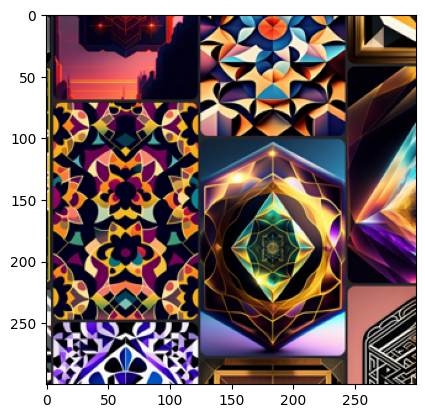

In [ ]:
#|eval: false
reg = Region(left=900, top=400, right=1600, bottom=1000)
img = f_resize_image(win32_view(location=reg), 300, 300)
img.shape, plt.imshow(img)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()